In [81]:
# imports
import hmmlearn
from hmmlearn import hmm
from hmmlearn import vhmm
import numpy as np
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import pickle
import seaborn as sns
from datetime import datetime

# Reading in the data

In [9]:
raw_df = pd.read_csv('~/UROP_transportation/data/I80_density.csv').dropna(axis=0)
raw_df.columns
all_columns = ['400126', '400176', '400691', '401242', '401698',
       '405602']

In [18]:
class Data():
    def __init__(self, columns, normalize=True):
        self.columns = columns
        self.normalize = normalize
        
        raw_df = pd.read_csv('~/UROP_transportation/data/I80_density.csv').dropna(axis=0)

        if normalize: # normalize data
            time_cache = {}
            for date in raw_df['Unnamed: 0']:
                time = date[-8:]
                if time not in time_cache:
                    mask = raw_df['Unnamed: 0'].str.contains(time)
                    same_time_df = raw_df[mask]
                    for column in self.columns:
                        # Calculate mean and standard deviation of the filtered values
                        mean_value = same_time_df[column].mean()
                        std_value = same_time_df[column].std()
                        # Apply z-score normalization to the 'Column' using the mean and standard deviation
                        normalized_values = (same_time_df[column] - mean_value) / std_value
                        # Assign the normalized values back to the DataFrame
                        raw_df.loc[raw_df['Unnamed: 0'].str.contains(time), column] = normalized_values
                time_cache[time] = 1

        self.dataframe = raw_df[columns]
        self.array = np.array(self.dataframe)

    def split_data(self, split):
        n_samples = self.array.shape[0]
        n_features = self.array.shape[1]

        num_training_points = math.floor(n_samples * split)
        self.training = self.array[0:num_training_points]
        self.testing = self.array[num_training_points:]
        
    def plot_flow_correlations(self):
        fig, ax = plt.subplots(figsize=(8,8))
        heatmap = ax.imshow(self.dataframe.corr())
        ax.set(xticks=[], yticks=[]);
        cbar = fig.colorbar(heatmap, ax=ax, shrink=0.8)
        plt.title('Segment Travel Time Correlations')
        plt.show()

# correlation heatmaps

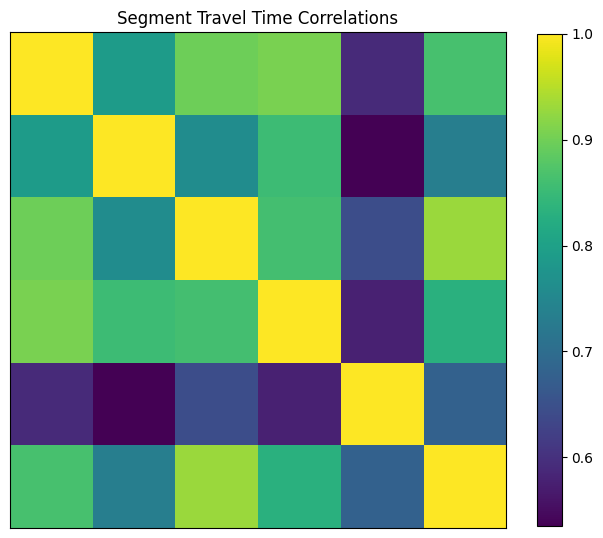

In [16]:
periodic_data = Data(columns = all_columns, normalize=False)
periodic_data.plot_flow_correlations()

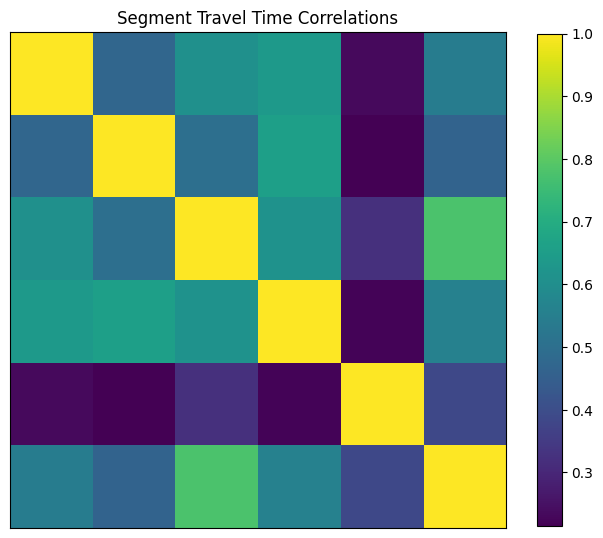

In [19]:
aperiodic_data = Data(columns = all_columns, normalize=True)
aperiodic_data.plot_flow_correlations()

# Setting up architecture

We set up a Hidden Markov model with a multivariate Gaussian emission function. The latent variable here are the states of the underlying Markov chain, which could possibly encode incidents. Right now I don't expect the model to work super well, because in the HMM, the observed (emission) traffic flows do not depend on each other, only on the underlying state of traffic, which in turn only depends on the previous traffic state. Perhaps for n segments of roads, O(n!) states would be sufficient for capturing relative order of traffic flows. Perhaps Gaussian emissions also doesn't make much sense with a discrete set of hidden states. Thus we will look into coding up a Linear Dynamical System (LDS) to capture continuous hidden states (with linear evolution + small Gaussian noise), and ideally the traffic flow emissions from continuous hidden states makes more sense. 

One downside to encoding traffic states as hidden states is that the model is less interpretable - it is unclear what kinds of states these traffic states are referring to, and we need many in order to get a reasonable accuracy. If we include certain latent variables encoding incidents into the hidden states, again it's not clear what our underlying structure between incidents and non-incidents should be.

In [110]:
# define custom type class VHMM model - each object is a model tied together with training data, testing data, predictions, etc.
# convenient to couple together model with associated scores/datasets/predictions

# design choices: 
    # want to keep passing in training_data and testing_data directly
    # rather than including methods for processing and splitting gtraining data, 
    # because potentially want to test on data from a different dataset (i.e. incidents)

class VHMM_Model():
    def __init__(self, num_components, covar_type, training_data=None, testing_data=None):
        """num_components: int, numbre of components
        covar_type: str, covariance type for model
        training and testing data: np.array types """
        self.num_components = num_components
        self.covar_type = covar_type
        self.training_data = training_data
        self.testing_data = testing_data
        self.n_samples = len(training_data) + len(testing_data)
        self.model = hmmlearn.vhmm.VariationalGaussianHMM(n_components=self.num_components, covariance_type=self.covar_type)
        self.score = None
        self.predicted_states_training = None
        self.predicted_states_testing = None
        self.predicted_flows_training = None
        self.predicted_flows_testing = None
        
    def train_model(self):
        converged = False
        while not converged:
            (self.model).fit(self.training_data, [len(self.training_data)])
            converged = (self.model).monitor_.converged
            if converged == False:
                print(f'model not converging for for num_components = {self.num_components}')
        return self.model
    
    def compute_score(self):
        self.score = (self.model).score(self.testing_data, [len(self.testing_data)])    
        return self.score
    
    def predict_states_and_flows(self):
        # self.model.means_ = list of means of gaussian emissions, indexed by state number
        self.predicted_states_training = self.model.predict(self.training_data, [len(self.training_data)])
        self.predicted_states_testing = self.model.predict(self.testing_data, [len(self.testing_data)])
        self.predicted_flows_training = [self.model.means_[state] for state in self.predicted_states_training]
        self.predicted_flows_testing = [self.model.means_[state] for state in self.predicted_flows_testing]
    
    def get_predicted_flows(self, column, train_or_test='test'):
        """column: str, column to get predicted flows for
        train_or_test: str in {'train', 'test'}, specify which dataset to predict flows for"""
    
        col_strings_to_index = {'400126': 0,
                           '400176': 1, 
                           '400691': 2,
                           '401242': 3,
                           '401698': 4,
                           '405602': 5}
        col_index = col_strings_to_index[column]
        if train_or_test == 'train':
            predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_training]
            return predicted_mean_flows
        # default to predicting flows on testing data
        predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_testing]
        return predicted_mean_flows
    
    def plot_predicted_flows(self, column, predicted_flows, time_range, train_or_test='test'):
        plt.figure(figsize=(25, 15), layout ='constrained')
        if train_or_test == 'training':
            selected_predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_training[time_range[0]:time_range[1]]]
            actual_flows = raw_df[column].tolist()[time_range[0]:time_range[1]]
        else:
            selected_predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_testing[time_range[0]:time_range[1]]]
            actual_flows = raw_df[column].tolist()[len(self.training_data)+time_range[0]:len(self.training_data)+time_range[1]]
        plt.plot(selected_predicted_mean_flows, color='red', label='predicted traffic flow means')
        plt.plot(actual_flows, color='blue', label='actual traffic flows')
        plt.xlabel('time')
        plt.ylabel('traffic flow')
        plt.title("Traffic flow predictions on segments " + str(column))
        plt.legend()
        plt.show()
    
    def plot_transmat(self):
        ax = sns.heatmap(self.model.transmat, linewidth=0.5)
        plt.show()

In [94]:
def train_all_models(num_components_range, covar_type, columns, train_test_split, normalize=False): 
    """columns: list, column names
    train_test_split: float, between 0 and 1, proportion of data used for training
    noralized: boolean, whether or not normalizing flow data across days to remove periodicity
    num_components_range: tuple, range for number of componenets in 
    covar_type: string, covariance type"""

    selected_data = Data(columns, normalize)
    selected_data.split_data(train_test_split)
    
    all_models = {num_components: VHMM_Model(num_components, covar_type, selected_data.training, selected_data.testing) for num_components in range(num_components_range[0], num_components_range[1])}
    
    for model in all_models.values():
        model.train_model()
        model.compute_score()
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(f'done training model {model} \n' + f'score = {model.score} \n' + f"current time = {current_time} \n" + "-------------")
        
    print('done training all models \n' + "-------------")
    return all_models
    
def plot_model_scores(all_models):
    # all_models: dictionary, keys = num_componenets & values = (trained) models
    plt.figure(figsize=(25, 15), layout ='constrained')
    num_components = list(sorted([idx for idx in all_models.keys()]))
    plt.plot([num_component for num_component in num_components], [all_models[num_component].score for num_component in num_components])
    plt.xlabel('num_components')
    plt.ylabel('log-likehood score of model')
    plt.title("Log-likehood for different number of components")

In [104]:
num_training_pts = math.floor(0.7 * len(raw_df))

def plot_predicted_flows(column, predicted_flows, end_time):
    plt.figure(figsize=(25, 15), layout ='constrained')
    plt.plot(predicted_flows[0:end_time], color='red', label='predicted traffic flow means')
    plt.plot(raw_df[column].tolist()[num_training_pts:num_training_pts+end_time], color='blue', label='actual traffic flows')
    plt.xlabel('time')
    plt.ylabel('traffic flow')
    plt.title("Traffic flow predictions on segments " + str(column))
    plt.show()

# creating and testing models

In [85]:
# setting up data
selected_cols = ['400126','400176','400691','401242']
# testing out up to 24 hidden states --> possibly all 4! = 24 permutations of the 4 travel segments needed for accurate predictions
all_models = train_all_models(num_components_range=(15,25), covar_type='full', columns=selected_cols, train_test_split=0.7, normalize=False)

done training model <__main__.VHMM_Model object at 0x12cc0e040> 
score = 696999.2840991316 
current time = 12:07:04 
-------------
done training model <__main__.VHMM_Model object at 0x12cc0edc0> 
score = 704007.653609825 
current time = 12:10:58 
-------------
done training model <__main__.VHMM_Model object at 0x12d003610> 
score = 690127.0104547618 
current time = 12:15:16 
-------------
done training model <__main__.VHMM_Model object at 0x12d0030d0> 
score = 692327.3599338853 
current time = 12:20:53 
-------------
done training model <__main__.VHMM_Model object at 0x12d003640> 
score = 692350.6507471215 
current time = 12:26:20 
-------------
done training model <__main__.VHMM_Model object at 0x12d0035b0> 
score = 690816.9434737707 
current time = 12:30:51 
-------------
done training model <__main__.VHMM_Model object at 0x12d0033d0> 
score = 698124.6150093646 
current time = 12:35:56 
-------------
done training model <__main__.VHMM_Model object at 0x12d003250> 
score = 699189.3651

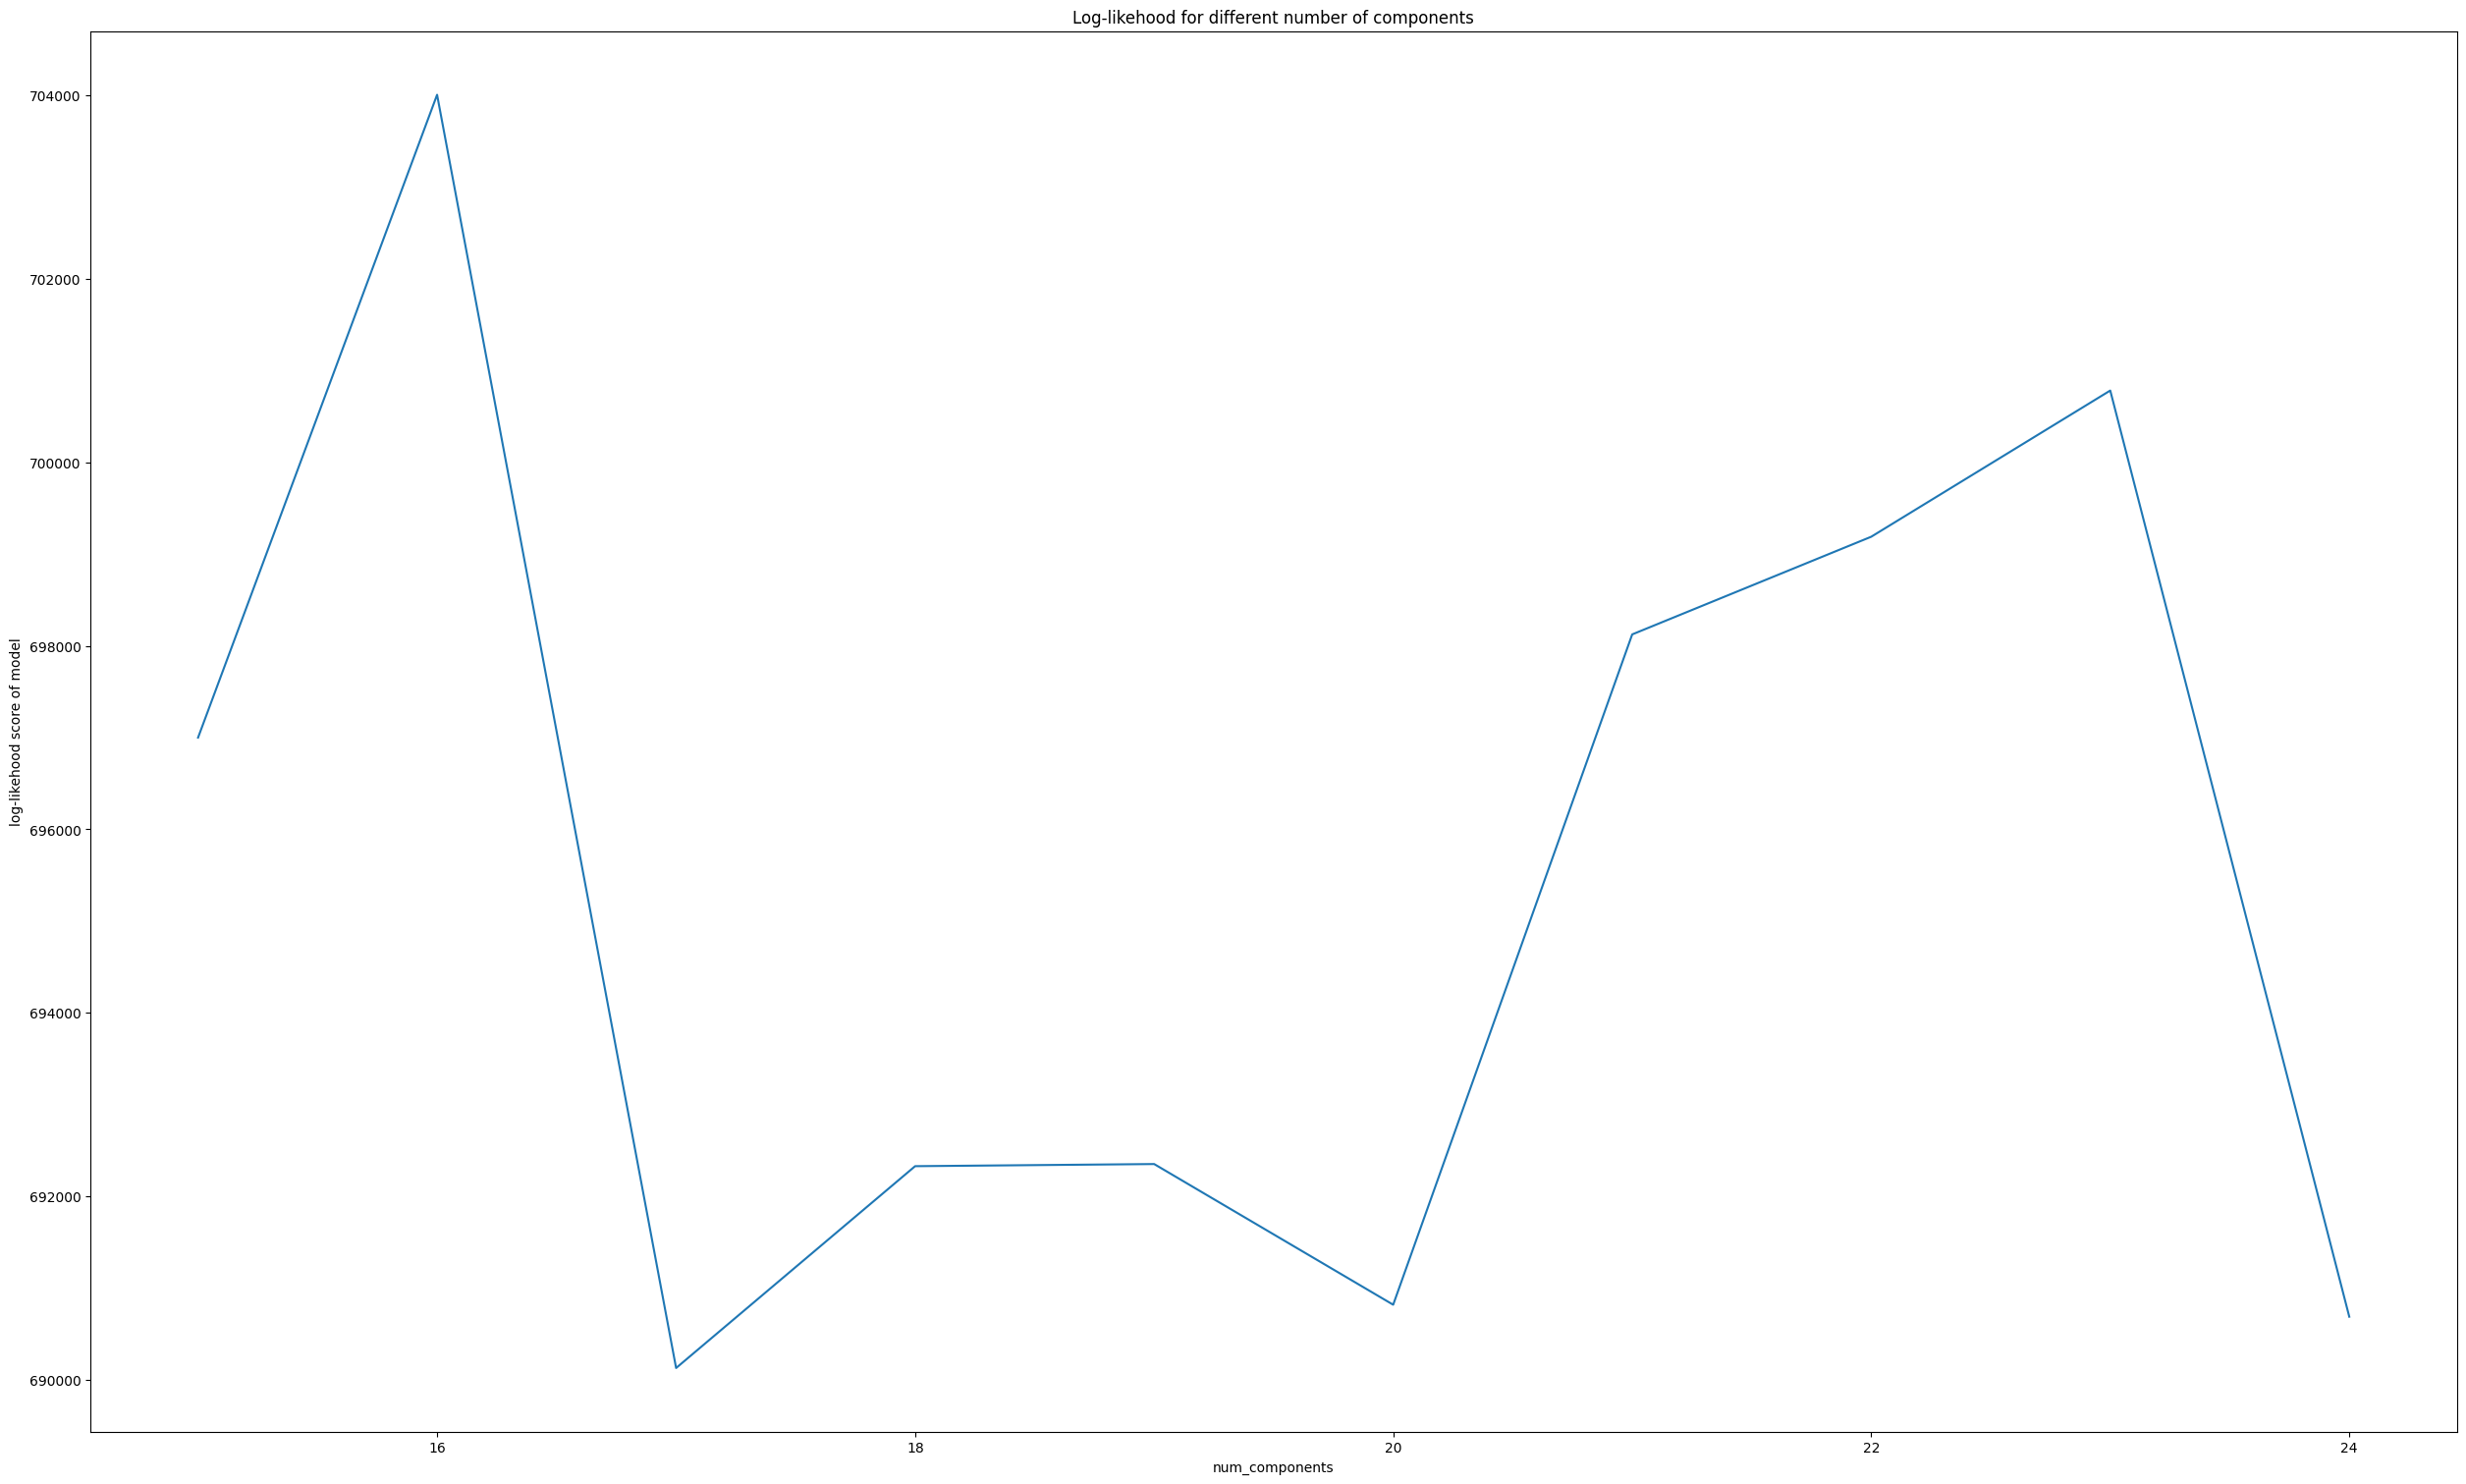

In [95]:
plot_model_scores(all_models)

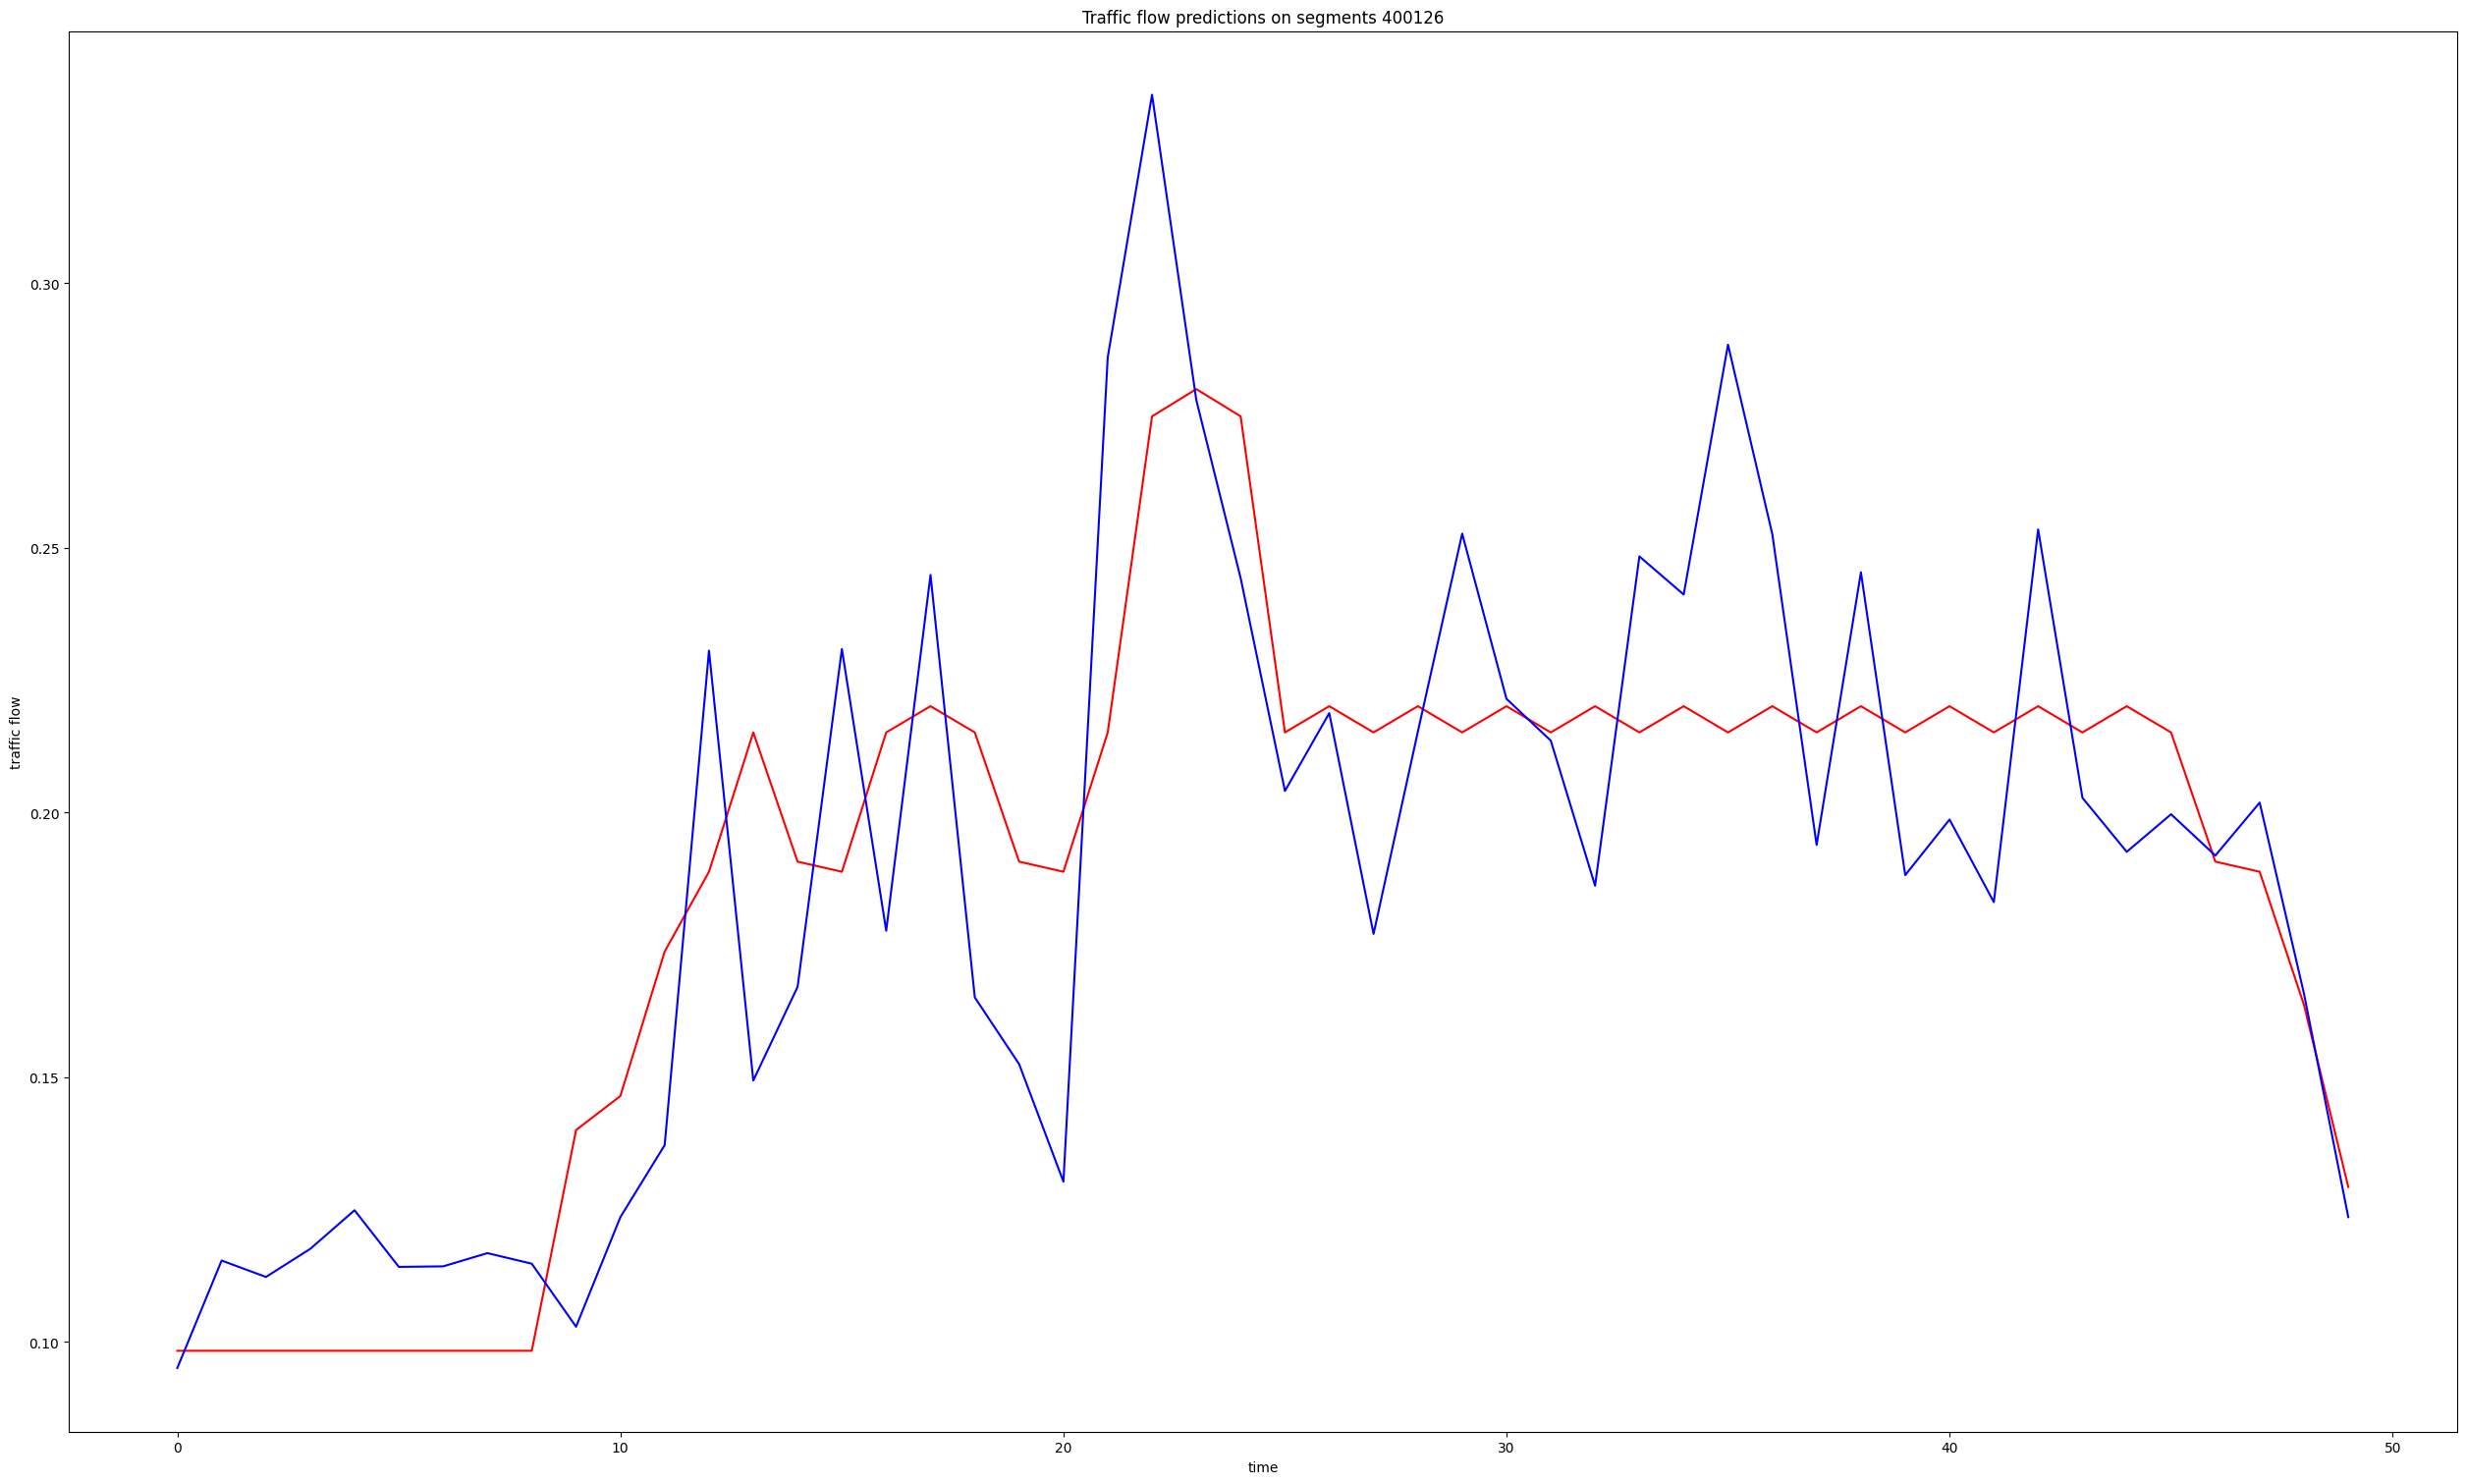

In [105]:
best_model = all_models[24]
best_model.predict_states()
predicted_flows = best_model.get_predicted_flows('400126')
plot_predicted_flows('400126', predicted_flows, 50)

# one step ahead prediction - state depends only on previous state
# extend this to include variance on the plot 

In [107]:
# setting up data
selected_cols = ['400126','400176','400691','401242']
# testing out up to 24 hidden states --> possibly all 4! = 24 permutations of the 4 travel segments needed for accurate predictions
all_models_normalized = train_all_models(num_components_range=(15,25), covar_type='full', columns=selected_cols, train_test_split=0.7, normalize=True)

done training model <__main__.VHMM_Model object at 0x12cb91340> 
score = -185957.99067715925 
current time = 15:39:14 
-------------
done training model <__main__.VHMM_Model object at 0x12cfe1040> 
score = -180524.75649683375 
current time = 15:43:03 
-------------
done training model <__main__.VHMM_Model object at 0x13f9422e0> 
score = -177641.94340700452 
current time = 15:47:00 
-------------
done training model <__main__.VHMM_Model object at 0x13f9421f0> 
score = -177632.73436332803 
current time = 15:51:21 
-------------
done training model <__main__.VHMM_Model object at 0x13f942340> 
score = -172464.27162450823 
current time = 15:56:08 
-------------
done training model <__main__.VHMM_Model object at 0x13f942790> 
score = -174581.43452962075 
current time = 16:01:32 
-------------
done training model <__main__.VHMM_Model object at 0x12e501e50> 
score = -170513.29071530516 
current time = 16:07:29 
-------------
done training model <__main__.VHMM_Model object at 0x12cc142e0> 
scor

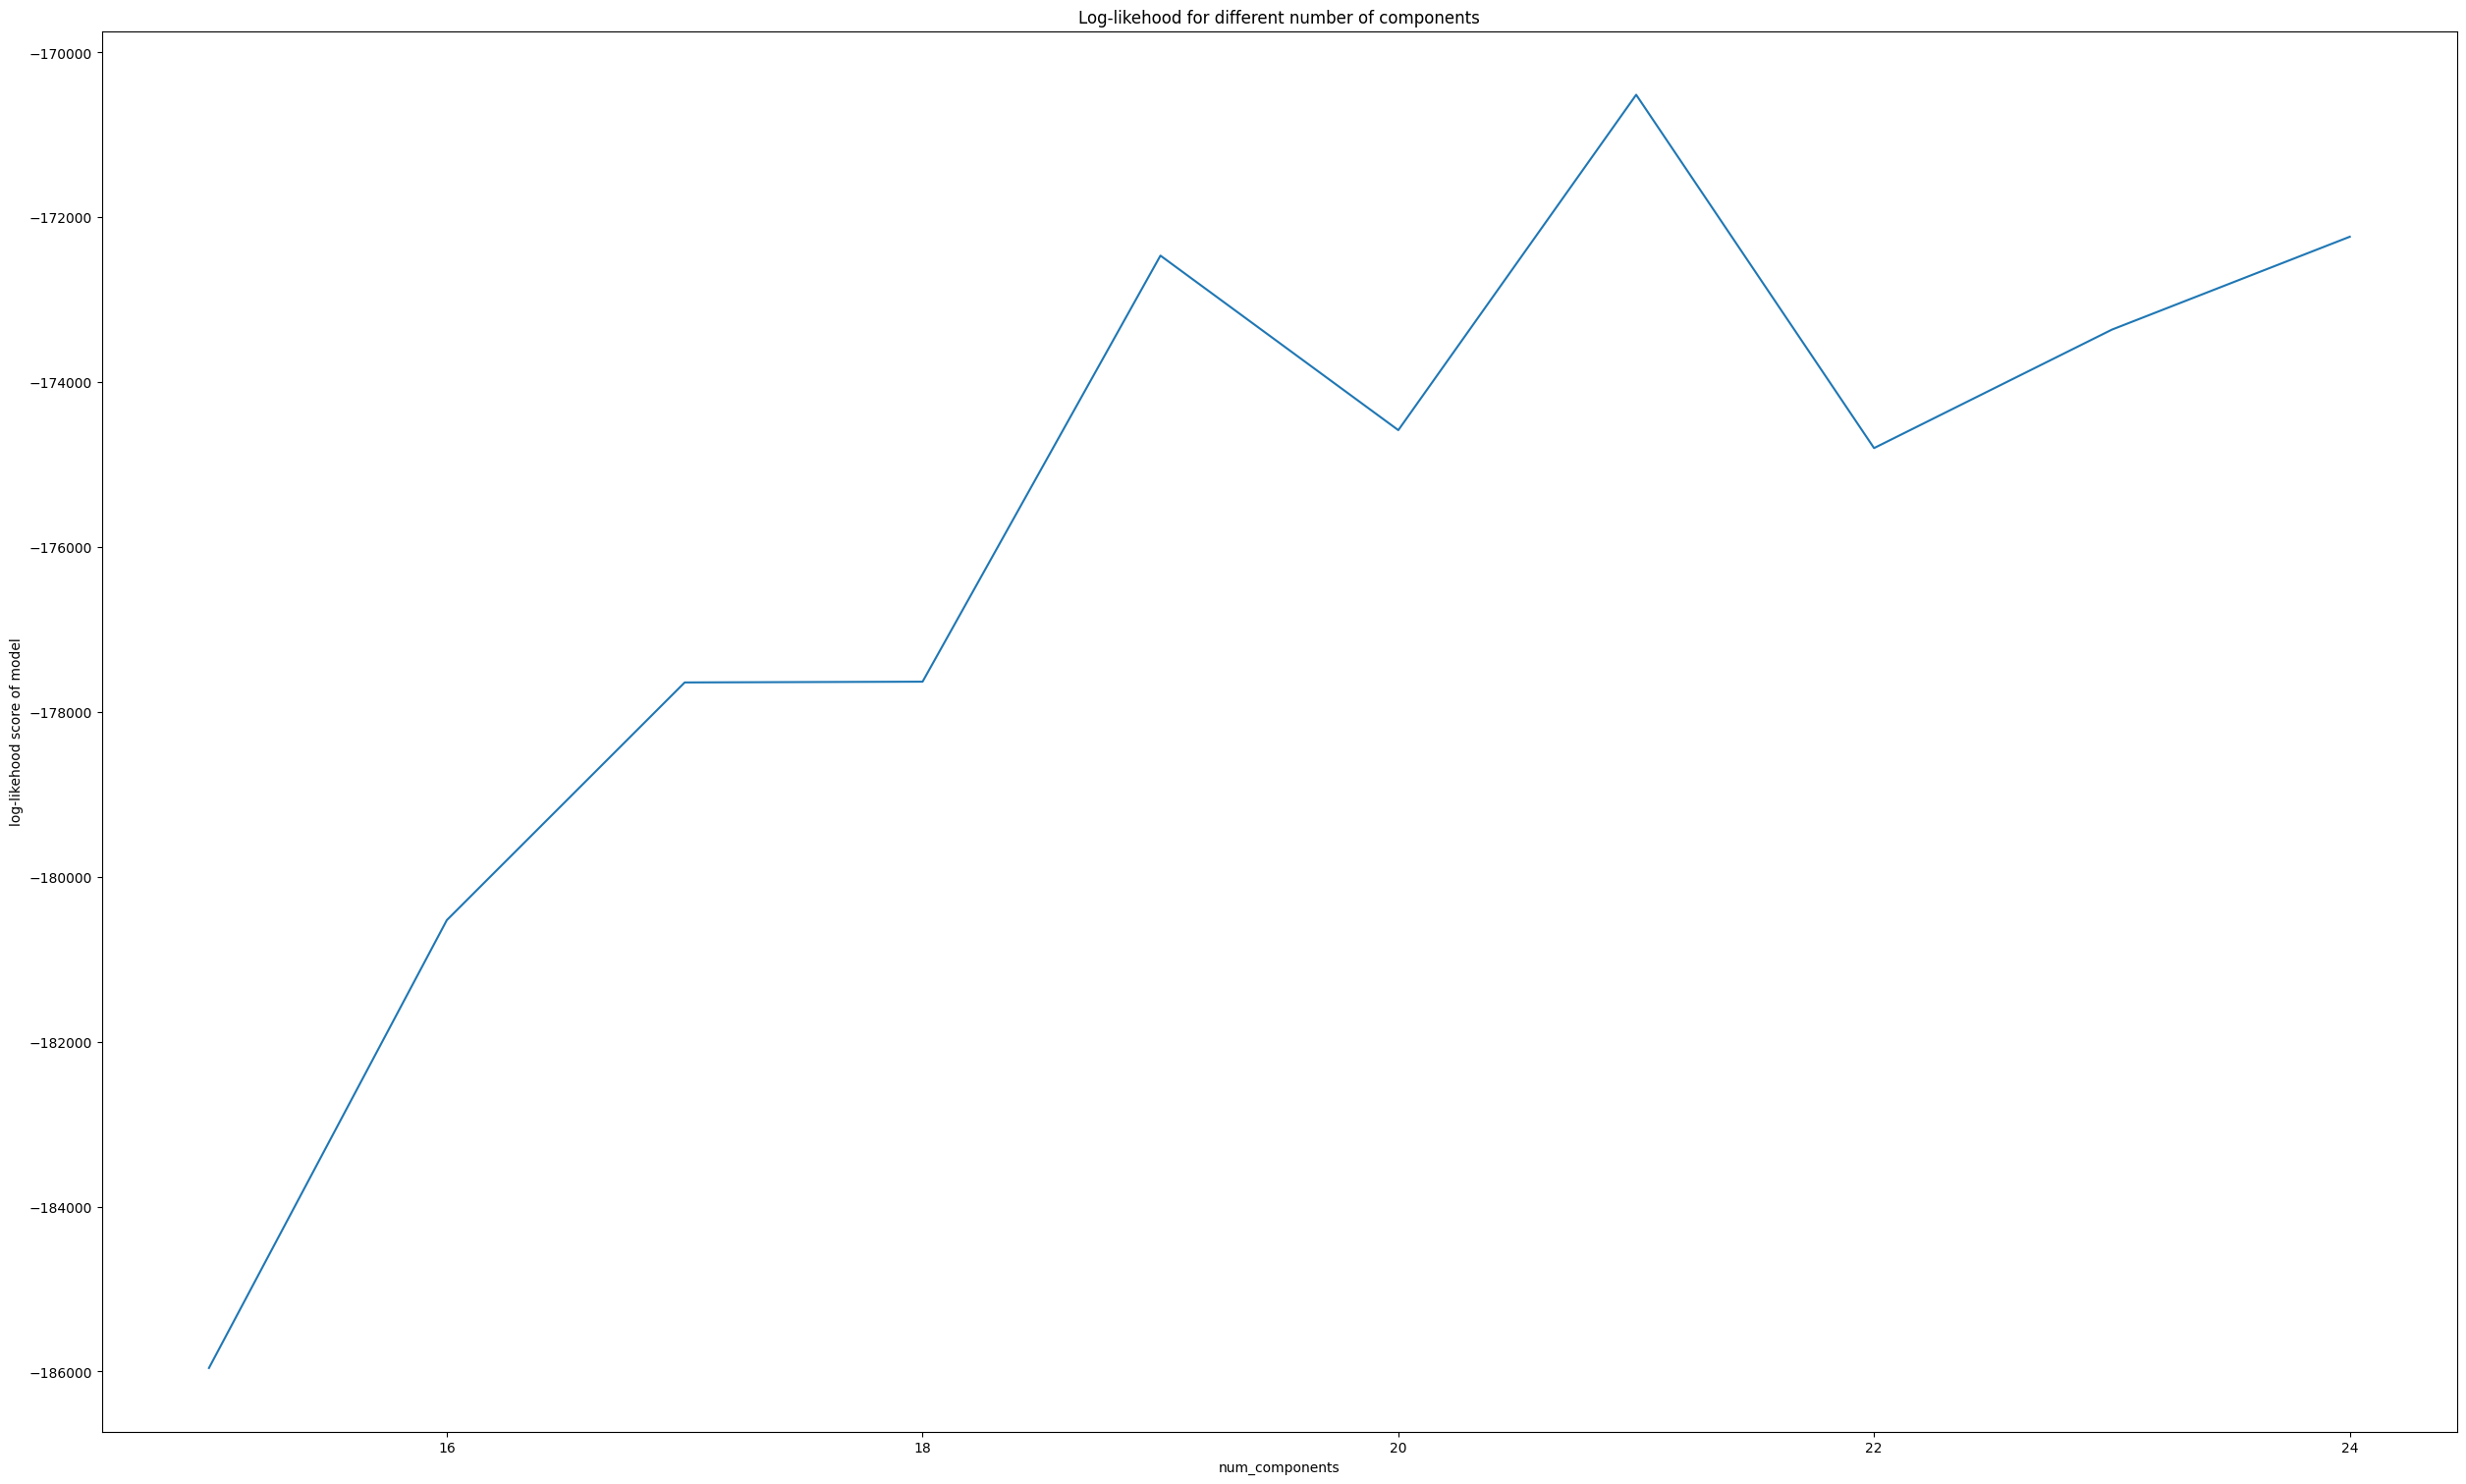

In [108]:
plot_model_scores(all_models_normalized)

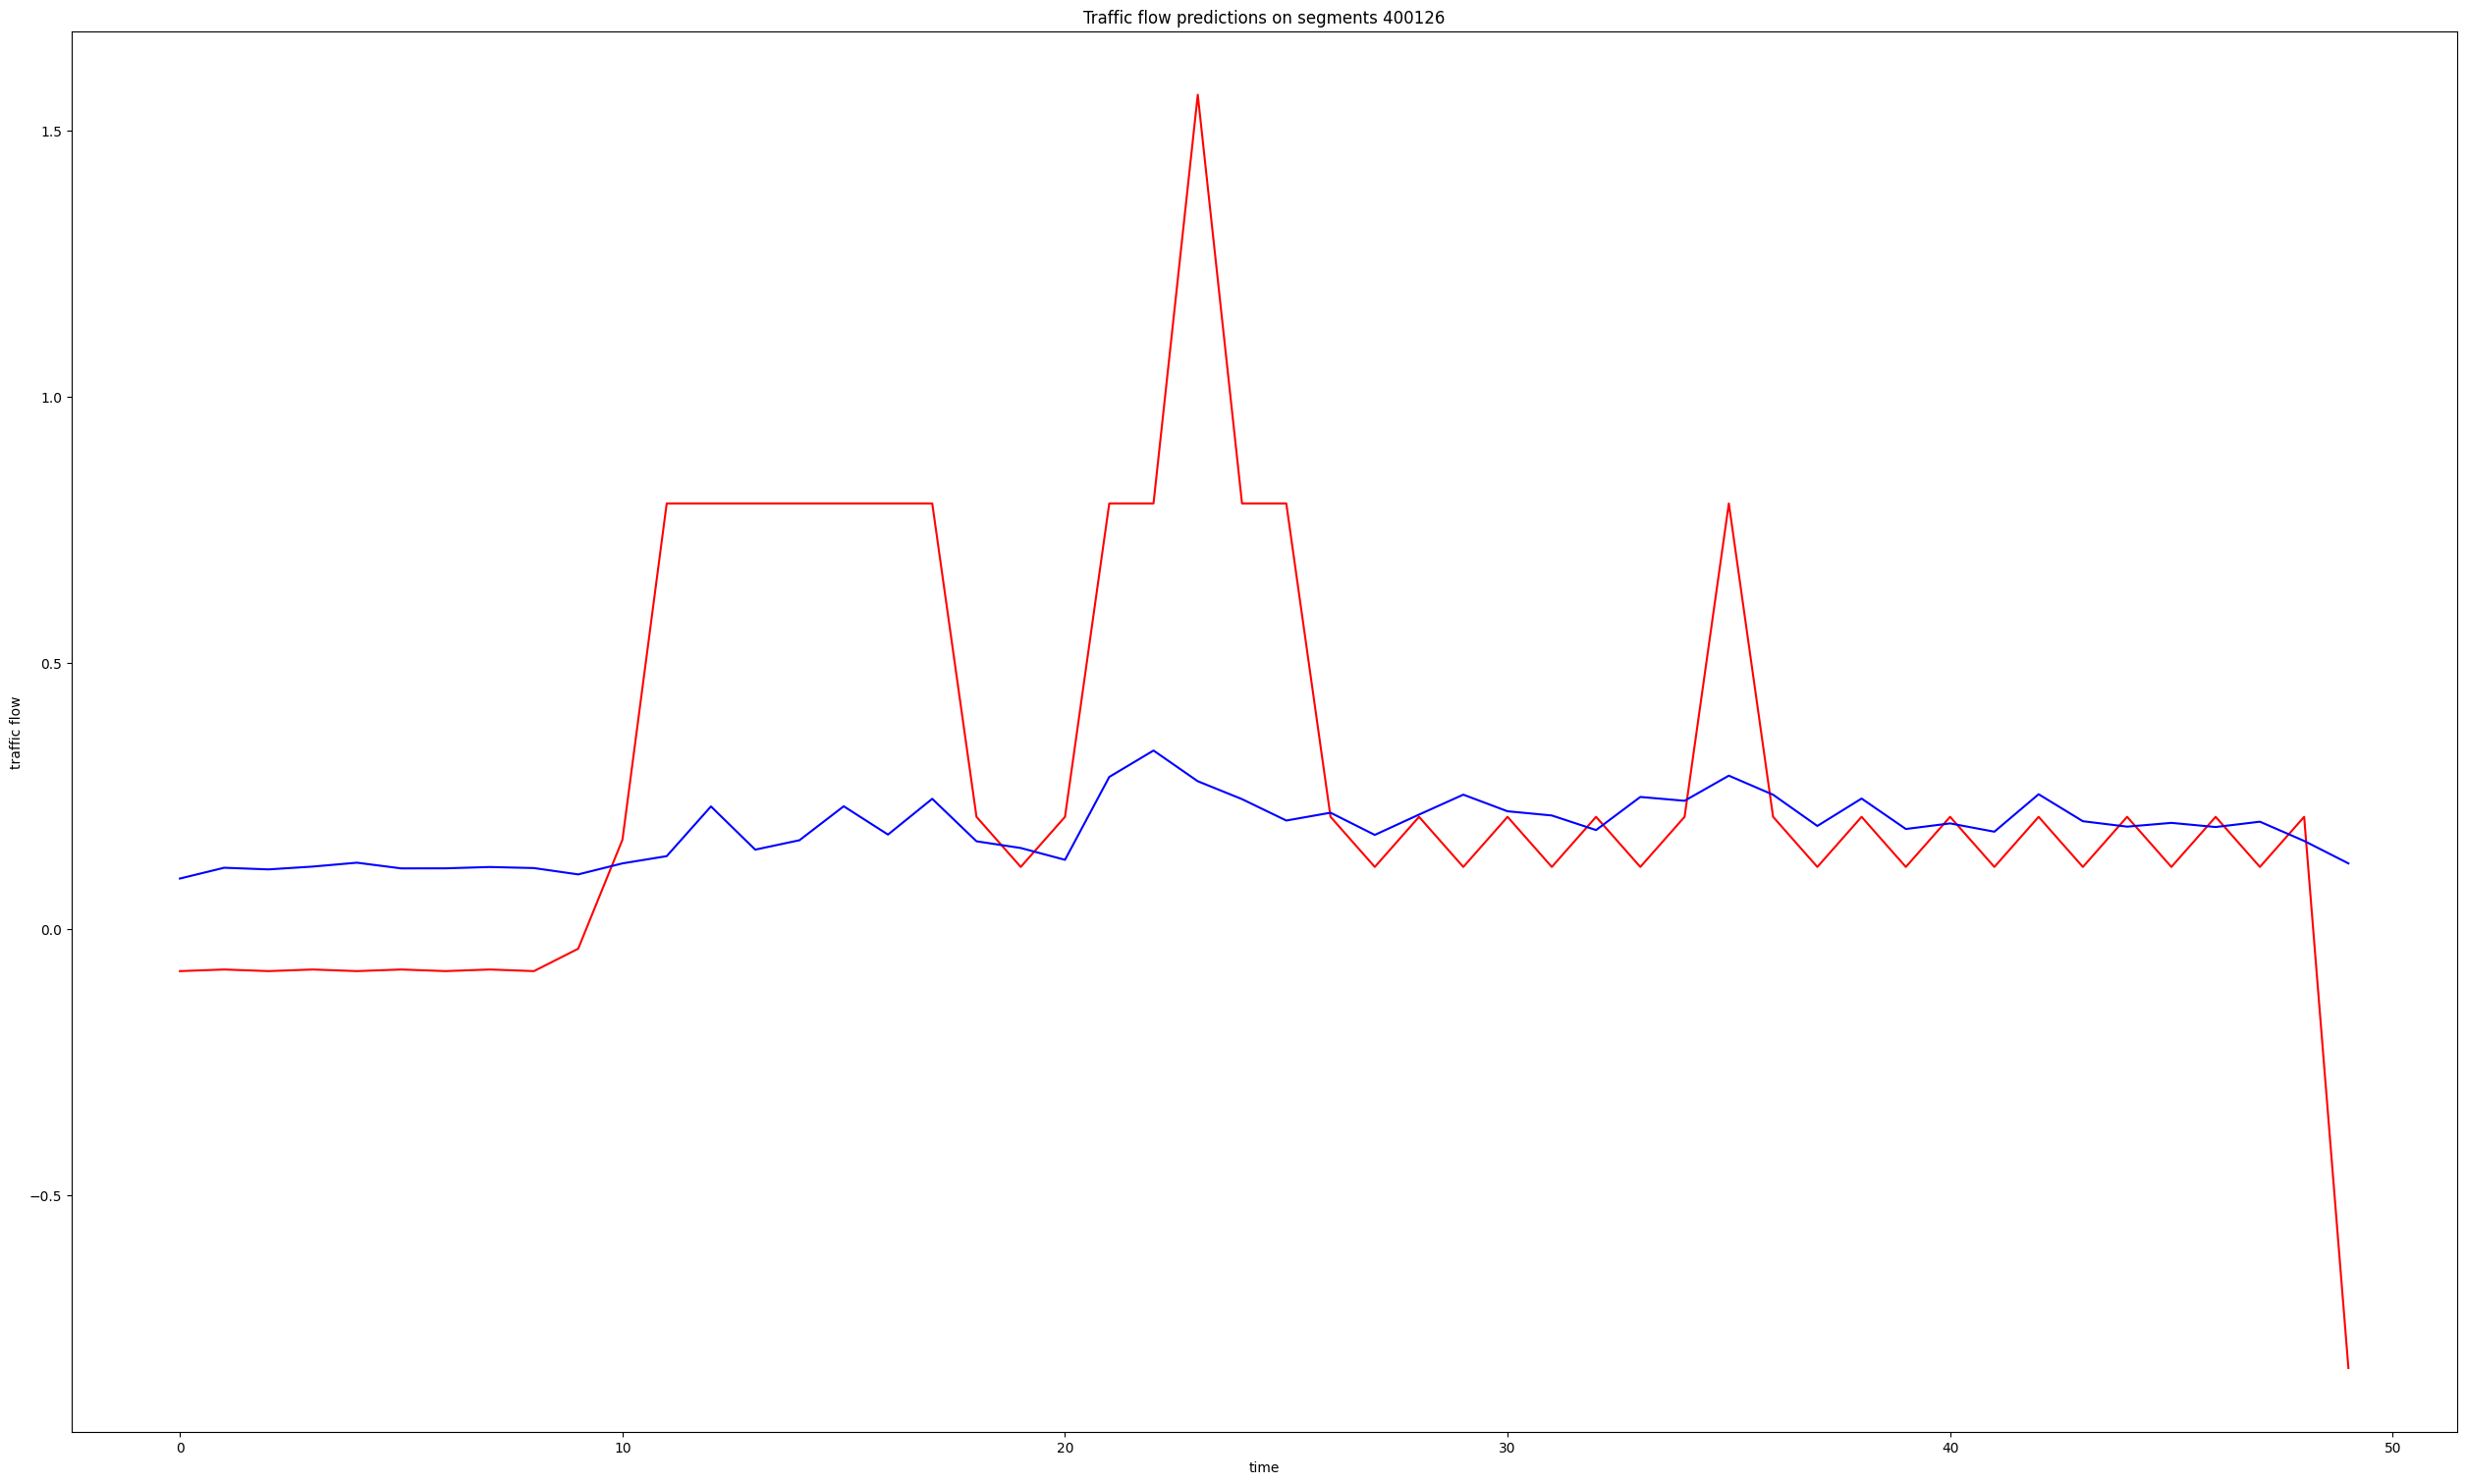

In [109]:
best_model = all_models_normalized[24]
best_model.predict_states()
predicted_flows = best_model.get_predicted_flows('400126')
plot_predicted_flows('400126', predicted_flows, 50)

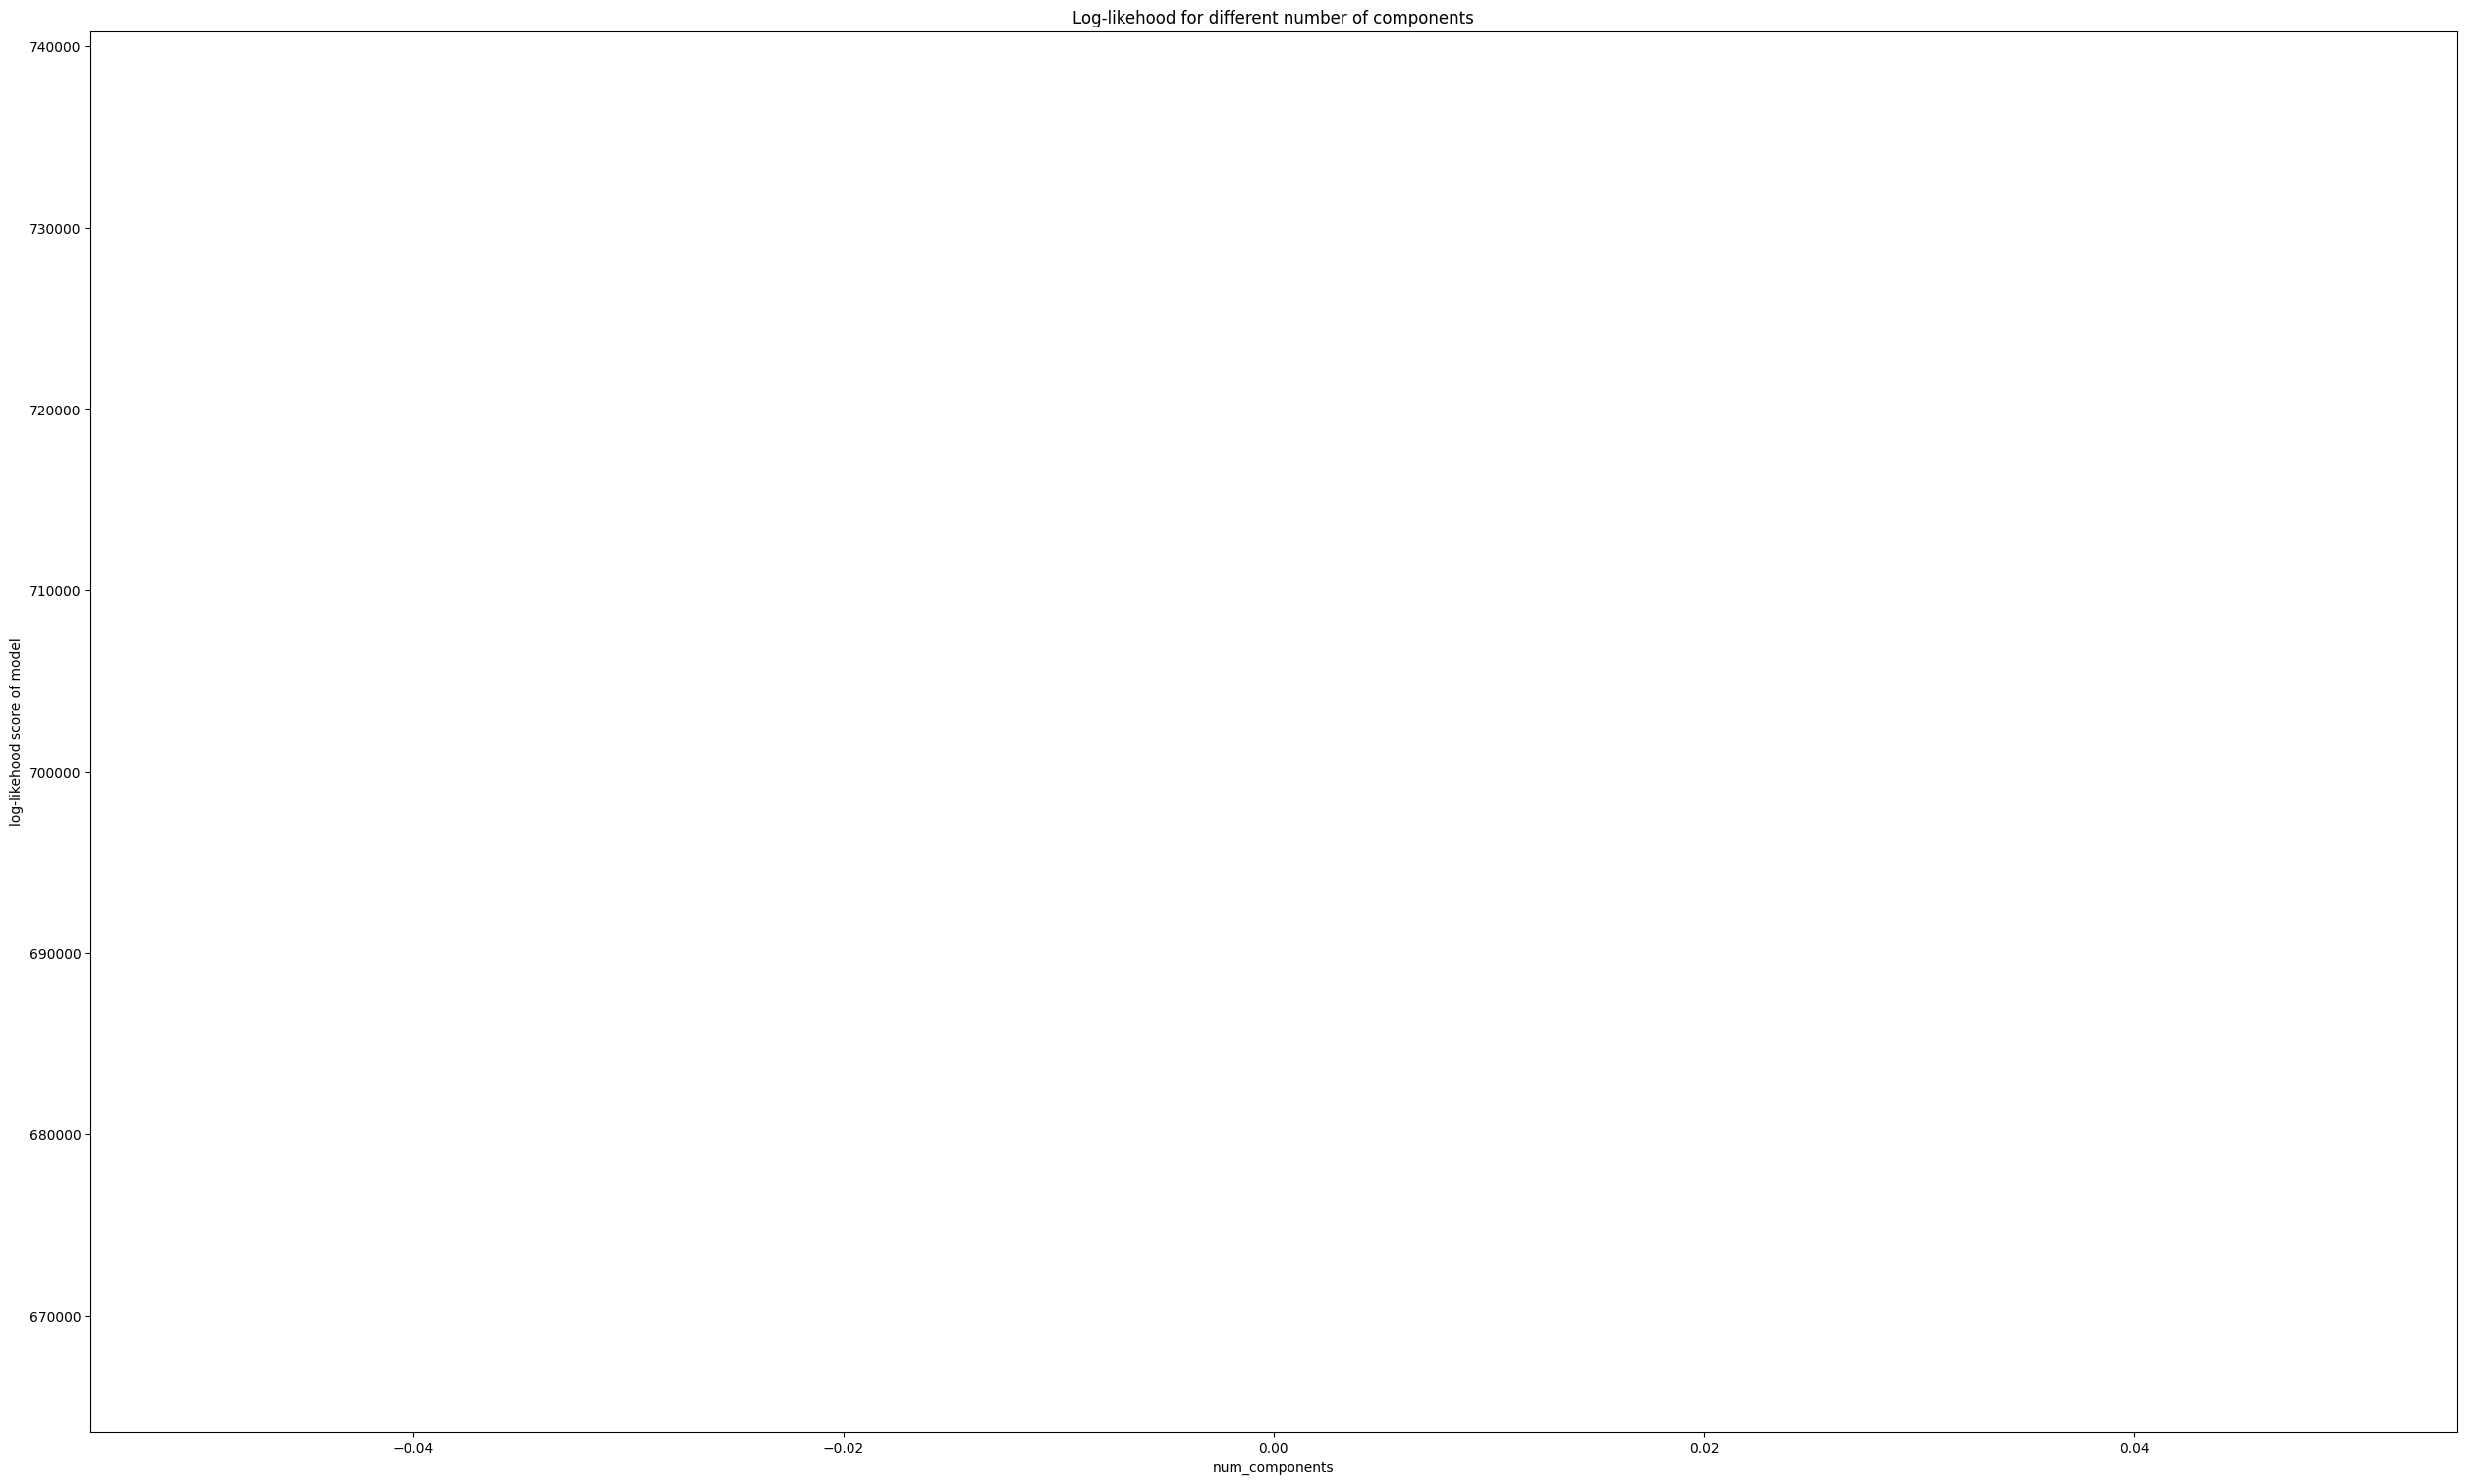

In [8]:
columns = ['400126','400176','400691','401242']
models, scores = train_all_models(columns, (24,25), "full")

In [98]:
# need to compute most likely states for observed traffic flows for the first n timesteps
# then plot the means of those states as the predicted mean traffic flows
# plot against observed traffic flows for first n timesteps

col_strings_to_index = {'400126': 0,
                       '400176': 1, 
                       '400691': 2,
                       '401242': 3}

def predict_traffic_flows(model, columns, predict_column, end_time): # column = string, name of traffic segment
    means = model.means_
    covars = model.covars_
    transmat = model.transmat_
    
    col_index = col_strings_to_index[column]
    
    states = model.predict(training_data, [training_index])
    predicted_mean_traffic_flows = [means[s][col_index] for s in states]
    
    plt.figure(figsize=(25, 15), layout ='constrained')
    plt.plot(predicted_mean_traffic_flows, color='red', label='predicted traffic flow means')
    plt.plot(raw_data[column].tolist()[0:end_time], color='blue', label='actual traffic flows')
    plt.xlabel('time')
    plt.ylabel('traffic flow')
    plt.title("Traffic flow predictions on segments " + str(columns))
    plt.show()

In [56]:

predict_traffic_flows(best_model, '400126', 50)

NameError: name 'predict_traffic_flows' is not defined

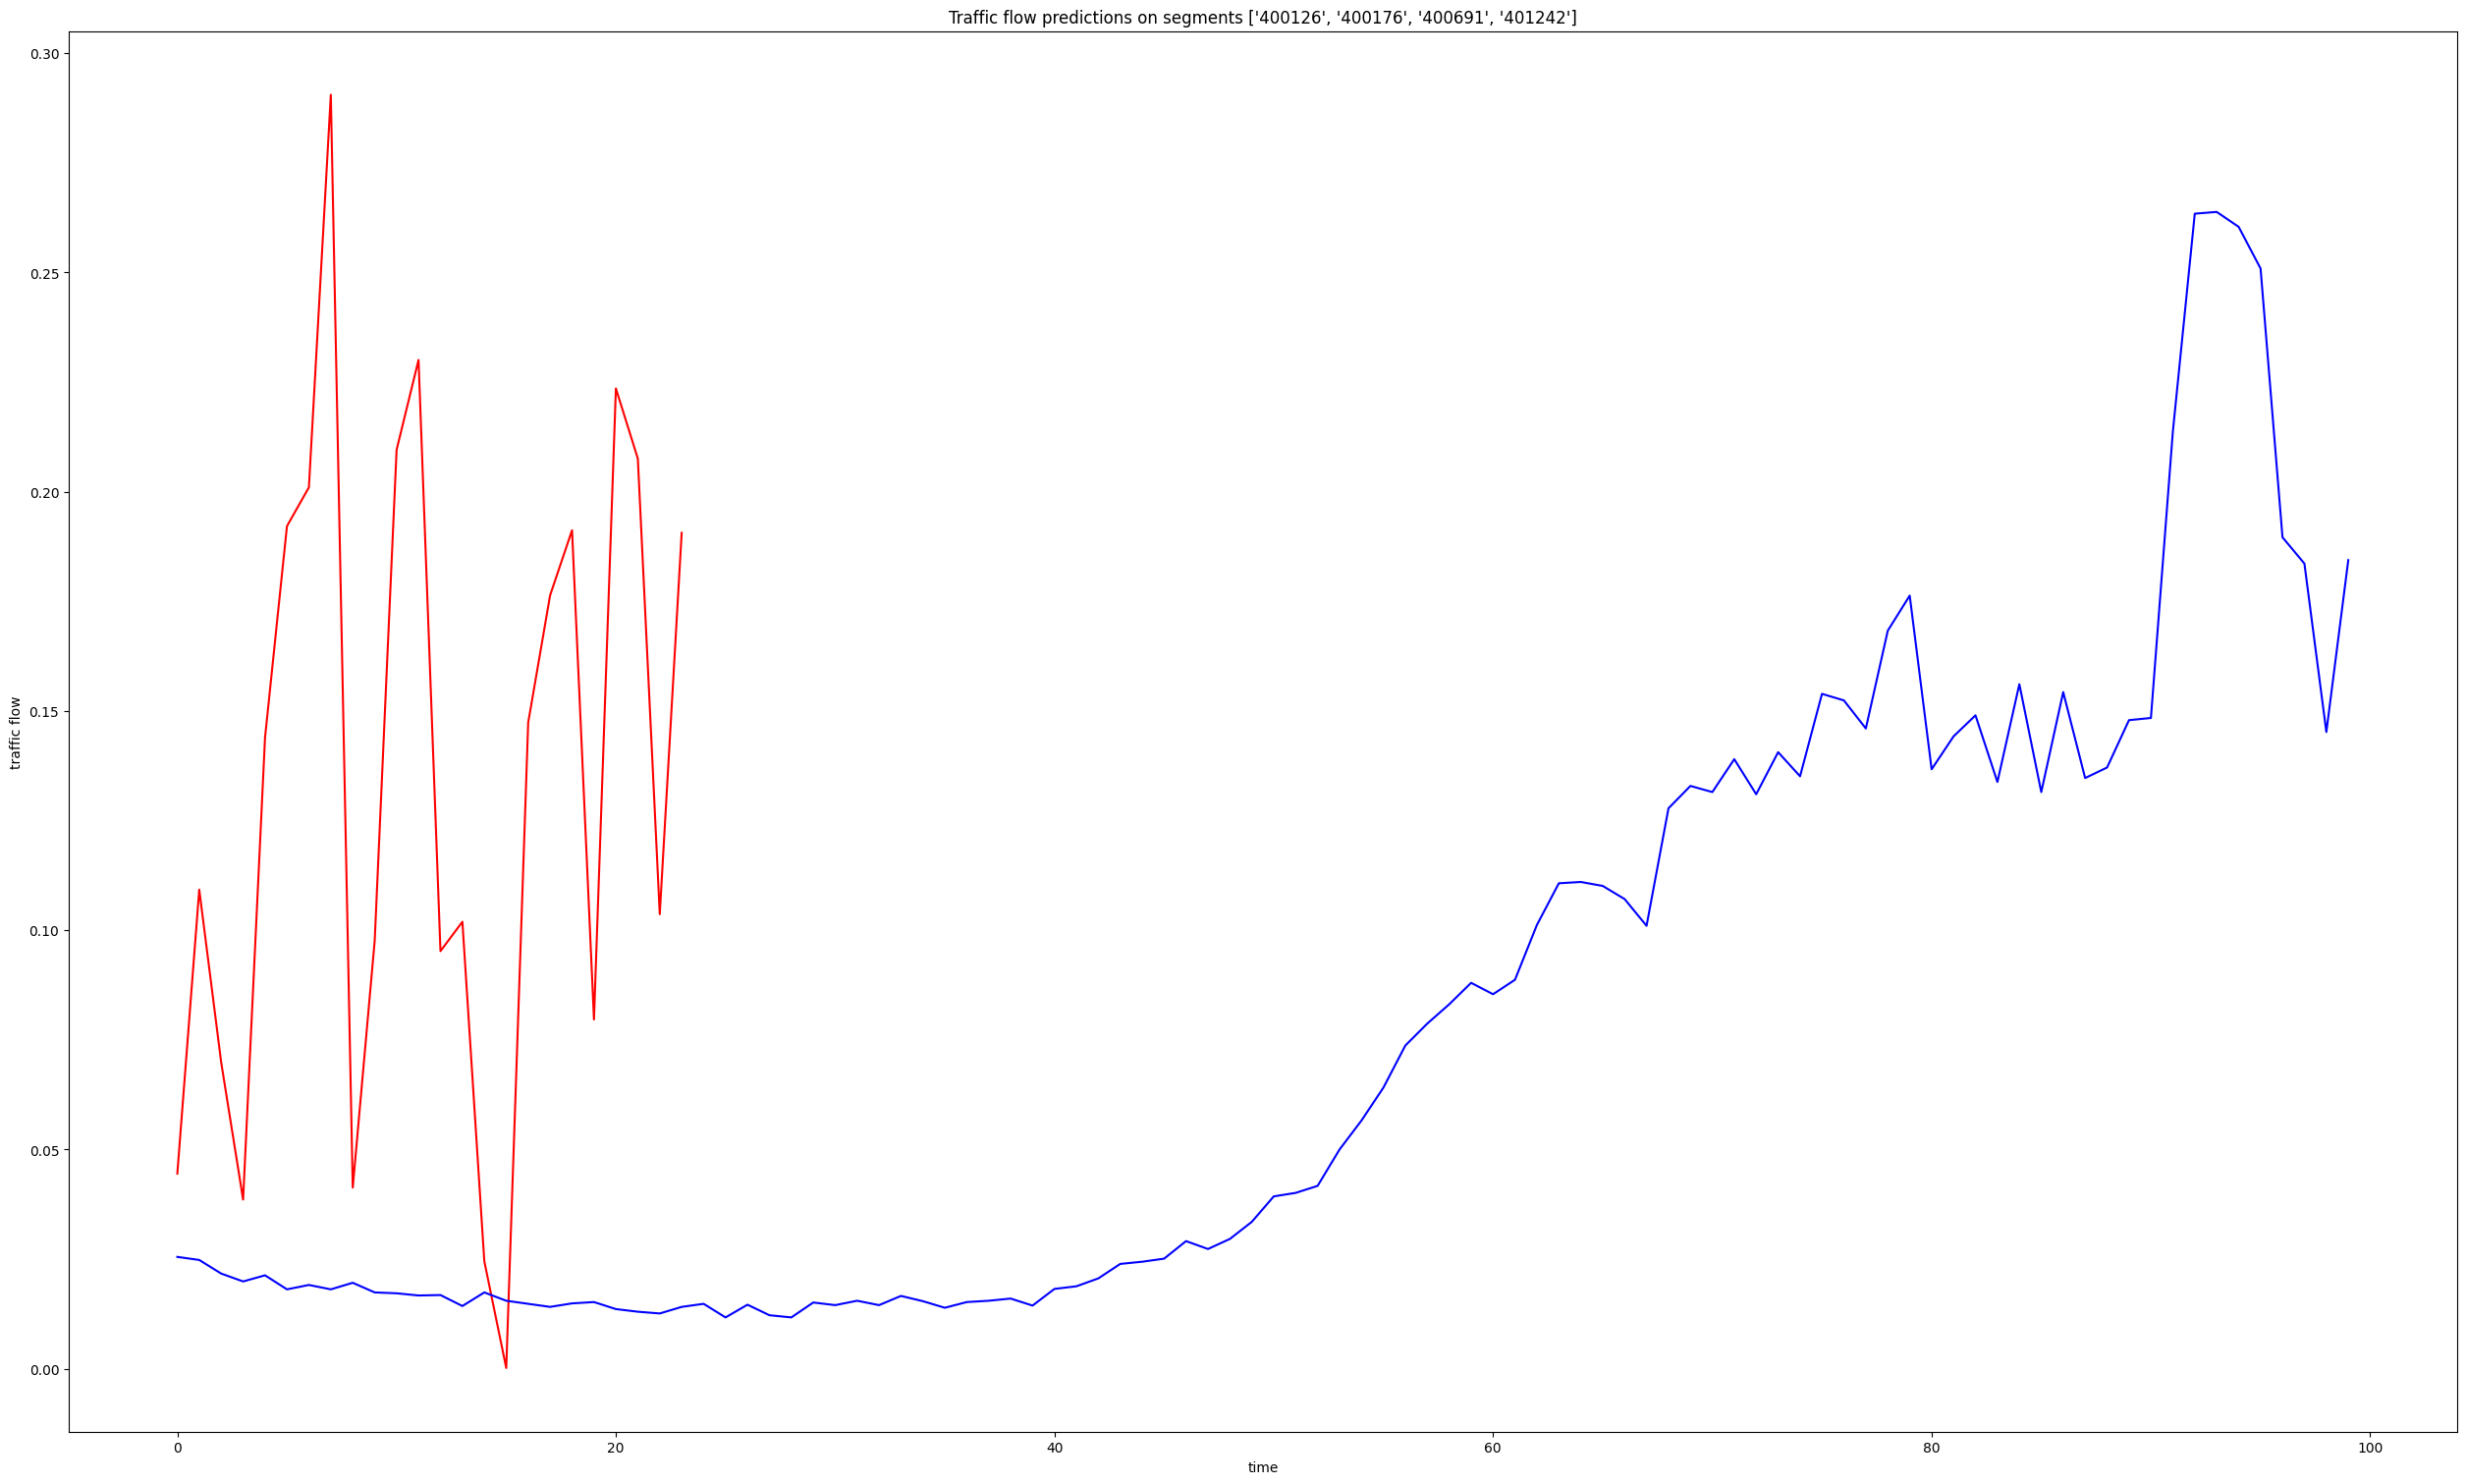

In [58]:
# predict_traffic_flows('400126', 100)

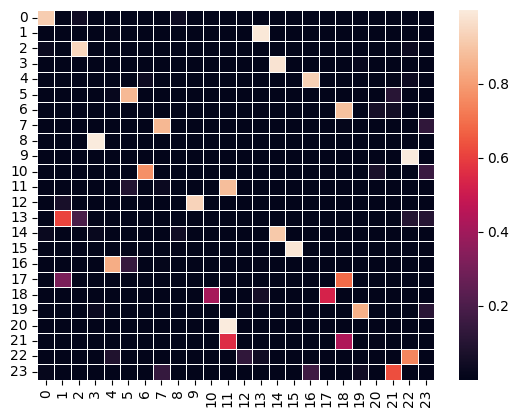

In [63]:
# plotting the transition matrix
import seaborn as sns
ax = sns.heatmap(transmat, linewidth=0.5)
plt.show()

the transition matrix is incredibly sparse - most of the parameters are close to 0. this is telling us that making the state space and thus transition matrix higher dimensional is probably not really helping us encode more information. rather, perhaps we should rely on a linear dynamical system with less parameters. a further advantage of LDS would be that the # of parameters scales with dimensionality of underlying space, not the number of hidden states, and thus we could still get essentially infinite hidden states while having to learn less parameters.

# normalizing out effects of demand

 (average flows of each 5m time interval over all days)

In [ ]:
# processing data (normalizing across days)
raw_data = pd.read_csv('~/UROP_transportation/data/I80_density.csv').dropna(axis=0)
flow_data = raw_data[['400126','400176','400691','401242','401698','405602']]
print(flow_data)

# flow_data_array = np.array(flow_data)
# print(f'flow data = {flow_data_array}, shape = {flow_data_array.shape}')

# n_samples = flow_data_array.shape[0]
# n_features = flow_data_array.shape[1]

# training_index = math.floor(n_samples * 0.7)
# training_data = flow_data_array[0:training_index]
# testing_data = flow_data_array[training_index:]

some notes about future models:
- means plot is not actually a prediction question, just another way of evaluating the model on observed 
- forecasting 2 hours ahead - basically simulate the trained model on the e.g. 30m before the 
    - compare # of components vs. forecasting ability
- benchmark against non-parametric models (NNs, SGDs, random forests)
- try using linear dynamical system model (basically hidden markov model, except hidden states evolve according to a fixed linear transformation at each time step with the addition of some small gaussian noise)
- look into perhaps models that allow more custom specification of underlying hidden states - perhaps discrete sets of continuous spaces? where one space corresponds to traffic flow evolution during no incidents, the other corresponds to incidents


combining HMM with linear regression 'emissions'
- most important next step: evaluate forecasting many timesteps ahead (i.e. 1 hour = 12 timesteps)